## 데이터셋 전처리
- 전처리 과정 자체는 동일하지만 라이브러리에서 가져와 사용하는 MNIST 데이터셋과 달리 직접 폴더에 접근하여 사용

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from collections import Counter

In [105]:
# 하이퍼파라미터 설정
num_epochs = 10
batch_size = 32
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 전처리 과정

1. **데이터 전처리**
    - `torchvision.transforms` 모듈을 활용하여 학습 및 테스트 데이터를 각각 전처리
        - **Resize**: 이미지를 `(224, 224)`로 크기 조정
        - **ToTensor**: 이미지를 텐서 형식으로 변환
        - **Normalize**: 각 채널의 평균과 표준편차를 사용하여 정규화 진행 (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`)

2. **DataLoader 설정**
    - `DataLoader`를 사용하여 학습, 검증, 테스트 데이터를 배치 크기에 맞게 불러오기
        - `dataset`: 각 데이터셋의 경로를 지정하여 어떤 데이터를 사용할 것인지 결정
        - `batch_size`: 미니 배치 크기를 설정하여 학습 속도를 조절
        - `shuffle`: 학습 데이터는 랜덤으로 섞어서 일반화 성능을 높이며, 검증 및 테스트 데이터는 섞지 않고 그대로 사용

In [106]:
# 데이터셋 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 데이터셋 로드
train_dataset = ImageFolder(root='./cnn_dataset/Training', transform=transform)
test_dataset = ImageFolder(root='./cnn_dataset/Test', transform=transform)
val_dataset = ImageFolder(root='./cnn_dataset/Validation', transform=transform)

In [109]:
# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## 🔥 모델 구축 - ResNet-18(BottleneckBlock)

1. **초기 합성곱 계층**
    - **7x7 커널, 스트라이드 2, 패딩 3** 설정으로 초기 합성곱 계층을 구성하여 입력 이미지의 특징을 추출
    - 입력 채널은 3(RGB 이미지), 출력 채널은 64로 설정하여 다양한 특징을 추출
    - 배치 정규화(`BatchNorm2d`)와 ReLU 활성화 함수 적용
    - `MaxPooling`(커널 크기 3, 스트라이드 2, 패딩 1)을 통해 특징 맵 크기를 절반으로 줄임

2. **병목 블록(BottleneckBlock)을 통한 잔차 학습 계층 구성**
    - `BottleneckBlock` 클래스를 사용하여 높은 차원의 입력을 더 작은 차원으로 축소한 뒤 복원하는 방식으로 잔차 학습을 수행
    - 각 BottleneckBlock은 세 개의 합성곱 계층과 배치 정규화를 포함하며, `ReLU` 활성화 함수를 사용해 비선형성을 부여함
    - 스킵 연결(skip connection) 사용: 입력과 출력이 차원 일치하지 않을 경우, 1x1 합성곱을 통해 차원을 맞춘 뒤 더해줌
        - 첫 번째 합성곱 계층(`conv1`): **1x1 커널**로 차원을 축소하여 연산 비용을 줄임
        - 두 번째 합성곱 계층(`conv2`): **3x3 커널**로 공간적 특징을 추출하고, 설정된 스트라이드로 다운샘플링 가능
        - 세 번째 합성곱 계층(`conv3`): **1x1 커널**로 차원을 원래대로 복원
    - 레이어 별 특징:
        - **Layer1**: 64 채널, BottleneckBlock 2개 사용
        - **Layer2**: 128 채널, BottleneckBlock 2개 사용, 스트라이드 2로 설정하여 다운샘플링
        - **Layer3**: 256 채널, BottleneckBlock 2개 사용, 스트라이드 2로 설정하여 다운샘플링
        - **Layer4**: 512 채널, BottleneckBlock 2개 사용, 스트라이드 2로 설정하여 다운샘플링

3. **잔차 학습과 스킵 연결**
    - 각 `BottleneckBlock`에서 입력을 그대로 다음 계층에 전달하는 스킵 연결을 적용해 정보 손실을 줄이고, 깊은 네트워크에서도 효과적으로 학습 가능
    - 스킵 연결의 차원 불일치가 발생하는 경우 1x1 합성곱을 통해 맞춰줌으로써 모델 안정성 유지

4. **평균 풀링 및 완전 연결 계층**
    - 마지막 특징 맵을 `AdaptiveAvgPool2d`로 입력의 크기와 상관없이 1x1로 축소
    - 특징을 `Linear` 완전 연결 계층에 전달해 최종 출력 크기 `num_classes=2`로 이진 분류 수행

5. **활성화 함수와 출력**
    - 각 합성곱 계층 뒤에 `ReLU` 활성화 함수 적용해 비선형성 추가
    - 최종 완전 연결 계층의 출력을 통해 각 클래스에 대한 예측 확률 산출

In [110]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion=4):
        super(BottleneckBlock, self).__init__()
        bottleneck_channels = out_channels // expansion
        
        # 1x1 합성곱 계층
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        
        # 3x3 합성곱 계층
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        
        # 1x1 합성곱 계층
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # 스킵 연결을 위한 차원 조정
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        out += self.shortcut(x)
        out = self.relu(out)
        
        return out

In [111]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### 모델 생성
`ResNet(BottleneckBlock, [2, 2, 2, 2], num_classes)`
- 블록의 종류: BottleneckBlock
- 레이어 별 블록 개수: 각 레이어마다 두 개의 블록 사용
- 분류할 클래스 수: 2 (x-ray 데이터셋은 이진 분류)

In [112]:
# ResNet-18 모델 생성
def ResNet18(num_classes=12):
    return ResNet(BottleneckBlock, [2, 2, 2, 2], num_classes)

# 모델 인스턴스화
model = ResNet18().to(device)

### 손실 함수와 옵티마이저

- **손실 함수**: 클래스 불균형을 고려하여 가중치가 적용된 `CrossEntropyLoss`를 사용
    - 클래스별 샘플 개수에 기반한 가중치 설정으로, `1 / 클래스 샘플 개수` 방식으로 클래스 가중치를 계산하여 모델이 적은 데이터 비율을 가진 클래스도 학습하도록 유도
    - Pytorch의 `CrossEntropyLoss`는 Softmax를 포함하여 다중 클래스 분류 문제에 적합

- **옵티마이저**: `Adam` 옵티마이저 사용
    - 학습 속도 향상 및 안정적인 수렴을 위해 Adam을 적용

In [ ]:
# 클래스별 샘플 개수 계산
class_counts = Counter([label for _, label in train_dataset.samples])
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(train_dataset.classes))], dtype=torch.float)

class_weights = class_weights.to(device)

# 가중치 적용된 손실 함수 정의
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(class_weights)

tensor([0.0007, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008], device='cuda:0')


In [ ]:
# TensorBoard 설정
##❗학습마다 다르게 설정해야 함
writer = SummaryWriter('./runs/basic_resnet_2/')

## 모델 학습
- 불러온 모델을 학습하고 손실함수와 학습 정확도, 검증 정확도를 측정한다.

In [115]:
# 학습 루프
best_val_acc = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # 검증
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    # TensorBoard에 로그 기록
    writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss / len(val_loader), epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
    
# 최고 성능 모델 저장
torch.save(best_model, 'best_resnet_model.pth')
writer.close()

Epoch [1/10], Train Loss: 1.2478, Train Acc: 55.37%, Val Acc: 60.43%
Epoch [2/10], Train Loss: 0.8015, Train Acc: 71.23%, Val Acc: 68.54%
Epoch [3/10], Train Loss: 0.6206, Train Acc: 76.89%, Val Acc: 76.00%
Epoch [4/10], Train Loss: 0.5079, Train Acc: 81.61%, Val Acc: 78.92%
Epoch [5/10], Train Loss: 0.4292, Train Acc: 84.43%, Val Acc: 77.30%
Epoch [6/10], Train Loss: 0.3688, Train Acc: 86.42%, Val Acc: 81.62%
Epoch [7/10], Train Loss: 0.3230, Train Acc: 88.31%, Val Acc: 78.81%
Epoch [8/10], Train Loss: 0.2806, Train Acc: 89.82%, Val Acc: 77.51%
Epoch [9/10], Train Loss: 0.2534, Train Acc: 90.93%, Val Acc: 82.92%
Epoch [10/10], Train Loss: 0.2206, Train Acc: 92.25%, Val Acc: 82.70%


In [116]:
# 테스트 셋으로 평가
model.load_state_dict(torch.load('best_resnet_model.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')

C:\Users\ho_e_\AppData\Local\Temp\ipykernel_11612\153978987.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet_model.pth'))


Test Accuracy: 83.88%


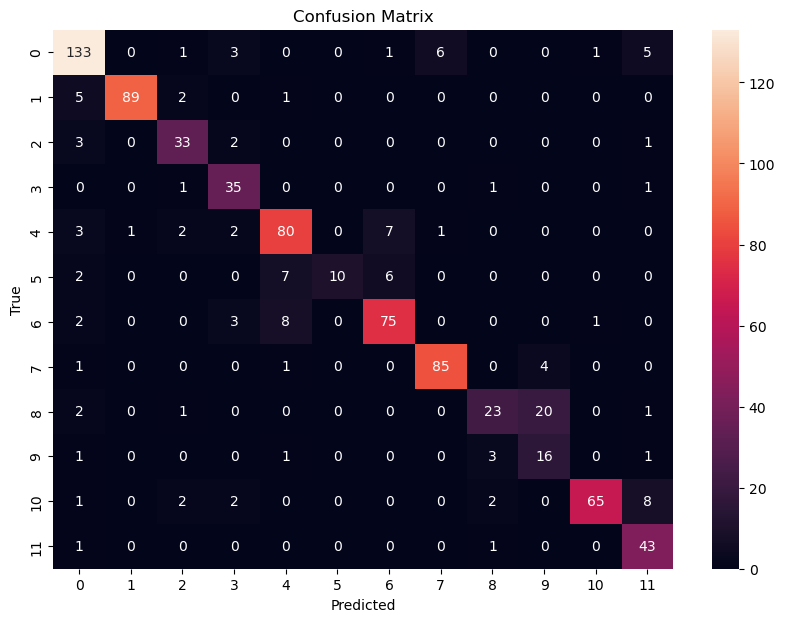

In [117]:
# 혼동 행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# TensorBoard 실행 (주석 처리된 상태)
%load_ext tensorboard
%tensorboard --logdir './runs/' --port 6021

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6021 (pid 26732), started 0:00:12 ago. (Use '!kill 26732' to kill it.)